# Tutorial
I’m going to explore the practical usages of topic model using the Gensim Library, such as finding structures for unknown datasets, classifying unlabeled data as well as improving accuracy of supervised learning.

## Introduction
This tutorial will introduce you several practical ways of using topic models with **Gensim Library**. In this tutorial I mainly focus on 2 kinds of topic models: *Latent Semantic Indexing (LSI)* and *Latent Dirichlet Allocation (LDA)*. In different cases, topic models can have different functionalities. Throughout this tutorial, you will learn how to use topic models to find structure for unknown datasets, classifying unlabeled data as well as improving the accuracy of supervised learning. Besides, in order to have a better views to the results, this tutorial also introduces some data visualization methods for reviewing topic models. 

We will cover the following topics in this tutorial:
- [Installing the libraries](#Installing-the-libraries)
- [Processing text](#Processing-text)
- [Visualizing Topic models](#Visualizing-Topic-models)
- [Training LSI model](#Training-LSI-model)
- [Training LDA model](#Training-LDA-model)
- [Finding structures of unknown text]
- [Classifying unlabeled data]

## Installing the libraries

Before getting started, you'll need to install the various libraries that we will use.  You can install Gensim, and NLTK using `pip`:

    $ pip3 install --upgrade gensim

    $ pip3 install -U nltk

When doing the examples, you might also need to use scikit-learn:

    $ pip3 install -U scikit-learn

In [235]:
import gensim,nltk,sklearn,time,random,numpy as np,matplotlib.pyplot as plt

## Processing text
Here we use the [20 newsgroups text dataset](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html) from sklearn datasets. We also use the same processing method as homework-3. Additionally, we also remove all the stopwords as well as rarewords in the document. 

In [2]:
from sklearn.datasets import fetch_20newsgroups
from text_process import process, tokenize, remove_stopwords

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training and the other one for testing. Since for basic topic models there is no better way to truly evaluate the topics than manually examine the results and see whether they made sense. So here I use both training and testing sets for generating the topic model. Since it might take longer time to generate the topic model for all of the data, here I randomly sample 1000 documents from all 18846 documents.

In [3]:
newsgroups = fetch_20newsgroups(subset='all',remove=('headers', 'footers', 'quotes'))

In [4]:
start = time.time()
docs_raw = [tokenize(doc) for doc in newsgroups.data]
docs = remove_stopwords(docs_raw)
k = 1000
sample_idxs = random.sample(range(len(docs)), k)  # 1000 samples from docs in order to do quick modeling
docs_sample = []
docs_raw_sample = []
for idx in sample_idxs:
    docs_sample.append(docs[idx]) 
    docs_raw_sample.append(docs_raw[idx])
end = time.time()
print("Processing time: " + str(end - start))

Processing time: 67.17970275878906


In order to generate topic models, we have to create the term dictionary of the chosen corpus and converting the corpus into document term matrix. 

In [6]:
# Creating the term dictionary of our corpus, where every unique term is assigned an index. 
dictionary_all = gensim.corpora.Dictionary(docs)
dictionary_sample = gensim.corpora.Dictionary(docs_sample)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix_all = [dictionary_all.doc2bow(doc) for doc in docs]
doc_term_matrix_sample = [dictionary_sample.doc2bow(doc) for doc in docs_sample]

# Use tf-idf model to help get each document's topic
tfidf = gensim.models.TfidfModel(doc_term_matrix_sample)
corpus_tfidf = tfidf[doc_term_matrix_sample]

## Visualizing Topic models

Plot the top words in each topic. (The plotting image as well as the belowing methods' will be shown in later chapters)

In [290]:
def plot_topicwords(num_top_words, topic_words, w, h, fontsize_base):
    import matplotlib as mpl
    mpl.rcParams['figure.figsize'] = (w,h)
    for t in range(topic_num):
        plt.subplot(6, 5, t + 1)  # plot numbering starts with 1
        plt.ylim(0, num_top_words + 1)  # stretch the y-axis to accommodate the words
        plt.xticks([])  # remove x-axis markings ('ticks')
        plt.yticks([]) # remove y-axis markings ('ticks')
        plt.title('Topic #{}'.format(t))
        top_words = [item[0] for item in topic_words[t][1]]
#         print("Topic {}: {}".format(t, ' '.join(top_words)))
        top_words_shares = [float(item[1]) for item in topic_words[t][1]]
        for i, (word, share) in enumerate(zip(top_words, top_words_shares)):
            if share < 0:
                word = '- ' + word
            else:
                word = '+ ' + word
            plt.text(0.1, num_top_words - 0.7 - i, word, fontsize=fontsize_base*abs(share))
    plt.tight_layout()
    plt.show()

Plot the percentage of topics for all the chosen documents.

In [251]:
def plot_topic_share(docs_topic, topic_num, w, h):
    plots = []
    N = len(docs_topic)
    height_cumulative = np.zeros(N)
    ind = np.arange(N)
    width = 0.2
    
    tmp = [[abs(val[1]) for val in doc_topic] for doc_topic in docs_topic]
    for val_ls in tmp:
        val_sum = sum(val_ls)
        for i in range(len(val_ls)):
            val_ls[i] = val_ls[i] / val_sum
    
    doctopic = np.array(tmp)
    
    mpl.rcParams['figure.figsize'] = (w,h)
    
    for k in range(topic_num):
        color = plt.cm.nipy_spectral(k/topic_num, 1)
        if k == 0:
            p = plt.bar(ind, doctopic[:, k], width, color=color)
        else:
            p = plt.bar(ind, doctopic[:, k], width, bottom=height_cumulative, color=color)
        height_cumulative += doctopic[:, k]
        plots.append(p)
    
    plt.ylim((0, 1)) 
    plt.ylabel('Topics')
    plt.title('Topics in docs')
    
    
    plt.xticks(ind+width/2, list(range(N)))
    plt.yticks(np.arange(0, 1, 10))
    
    topic_labels = ['Topic #{}'.format(k) for k in range(topic_num)]
    plt.legend([p[0] for p in plots], topic_labels)
    plt.show()

Plot the hotmap of the topics in all the chosen map

In [246]:
def plot_topic_val(docs_topic, topic_num, width, height):
    tmp = [[(val[1]) for val in doc_topic] for doc_topic in docs_topic]
    doctopic = np.array(tmp)
    topic_labels = ['Topic #{}'.format(k) for k in range(topic_num)]
    
    plt.pcolor(doctopic, norm=None, cmap='nipy_spectral')
    mpl.rcParams['figure.figsize'] = (width, height)
    
    plt.yticks(np.arange(doctopic.shape[0])+0.5, list(range(doctopic.shape[0])));
    plt.xticks(np.arange(doctopic.shape[1])+0.5, topic_labels);
    plt.gca().invert_yaxis()
    plt.xticks(rotation=90)
    plt.colorbar(cmap='nipy_spectral')
    plt.tight_layout()
    plt.show()

## Training LSI model

In [287]:
topic_num = 30
Lsi = gensim.models.lsimodel.LsiModel
lsimodel = Lsi(doc_term_matrix_sample, num_topics=topic_num, id2word = dictionary_sample)

In [288]:
topic_words = lsimodel.show_topics(formatted=False)
corpus_lsi = lsimodel[corpus_tfidf]

In [305]:
print(corpus_lsi[0])

[(0, 0.05643479585062557), (1, 0.012827498655405918), (2, -0.007183409899413037), (3, 0.06941034927702389), (4, -0.011405428594712748), (5, 0.05360876260613378), (6, -0.007376396606807588), (7, -0.0025623745427685645), (8, -0.018378343219913326), (9, 0.00548281606800311), (10, -0.0008558988138020853), (11, 0.013750522097784908), (12, 0.01106533471366171), (13, -0.008048813108350837), (14, 0.00913659431913741), (15, 0.029315120752812812), (16, -0.0018972795102808787), (17, 0.004958235957967938), (18, 0.01910612693135924), (19, -0.012850192083929266), (20, -0.023316344376949606), (21, 0.009384028293584198), (22, 0.005827618443091312), (23, -0.003124466112928716), (24, 0.01647094746641269), (25, 0.01092127113321339), (26, 0.0006536615330107324), (27, 0.01717953930169688), (28, -0.012732805718279755), (29, -0.005612310564957876)]


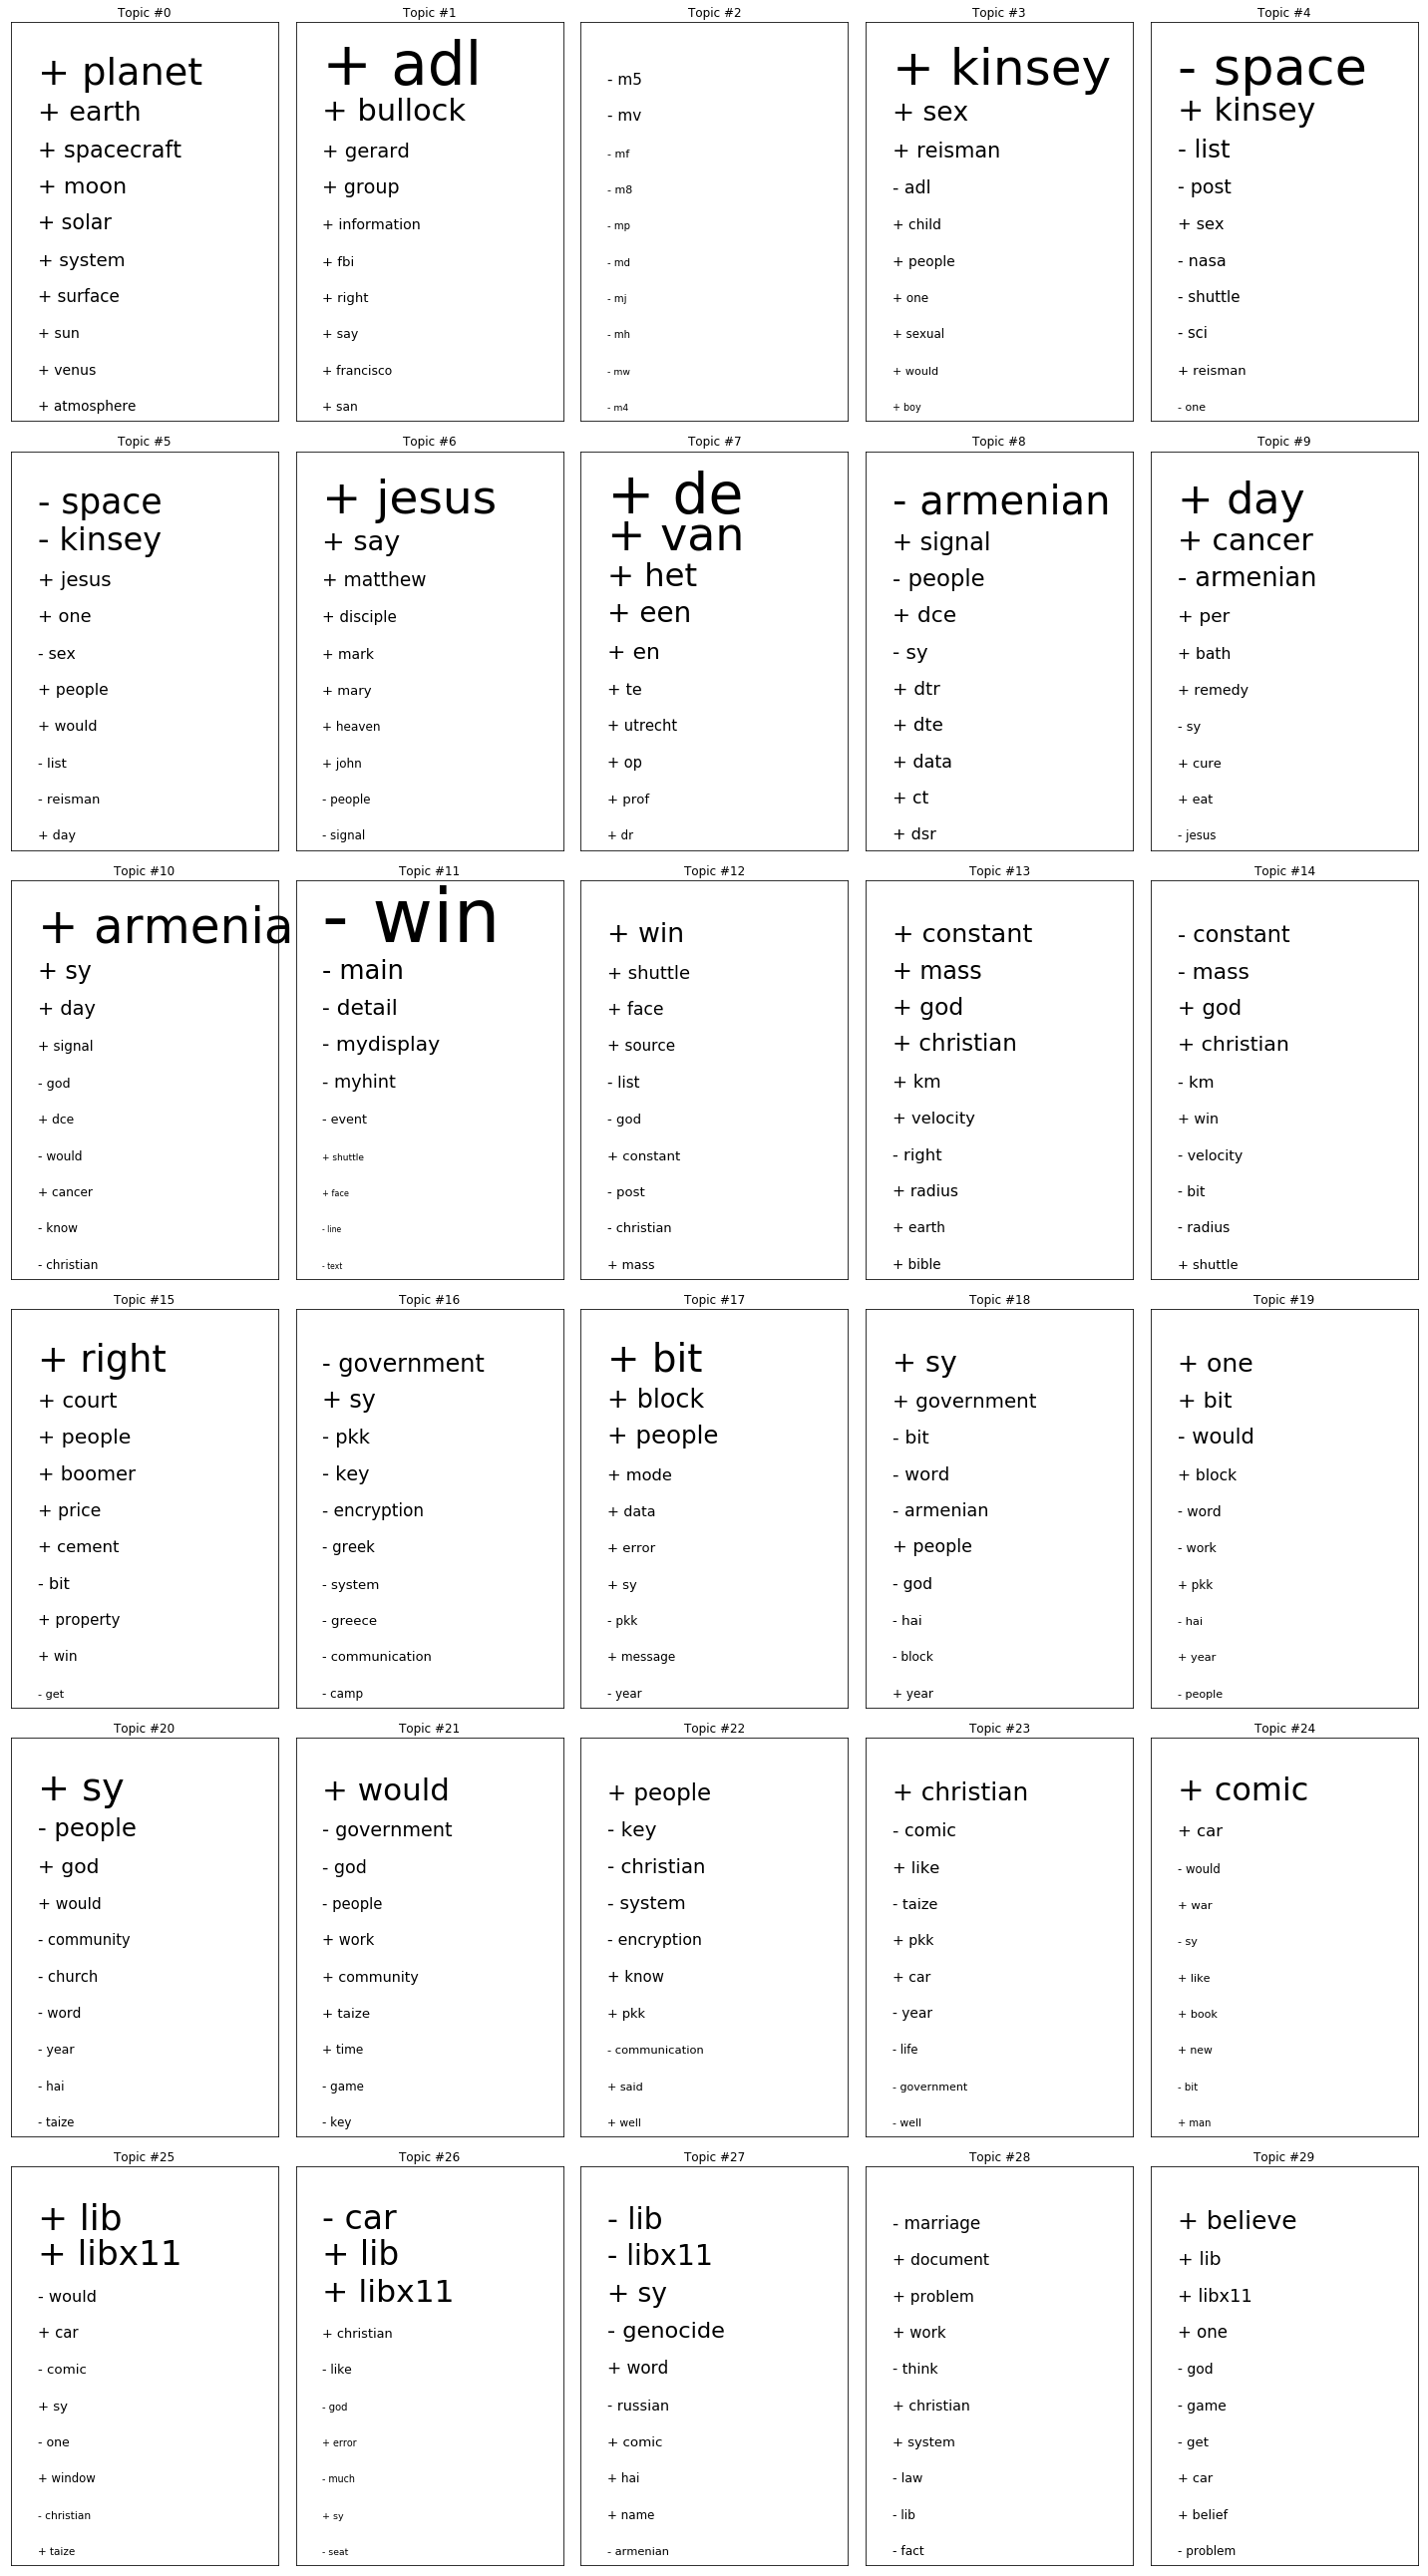

In [291]:
plot_topicwords(10, topic_words, 20, 36, 100)

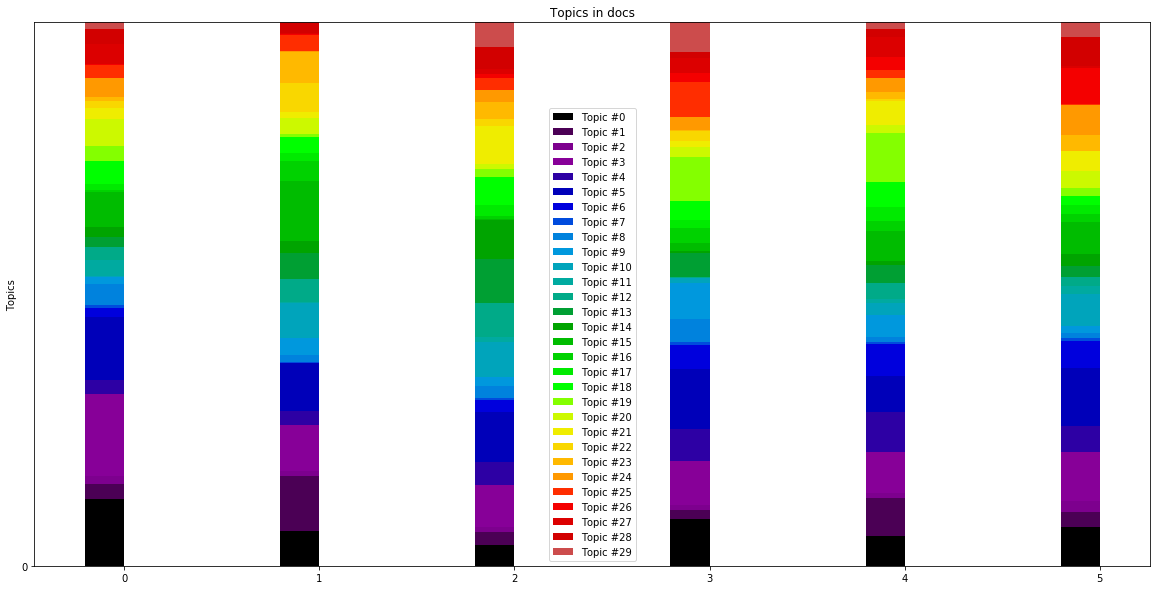

In [292]:
plot_topic_share(corpus_lsi[:6], topic_num, 20, 10)

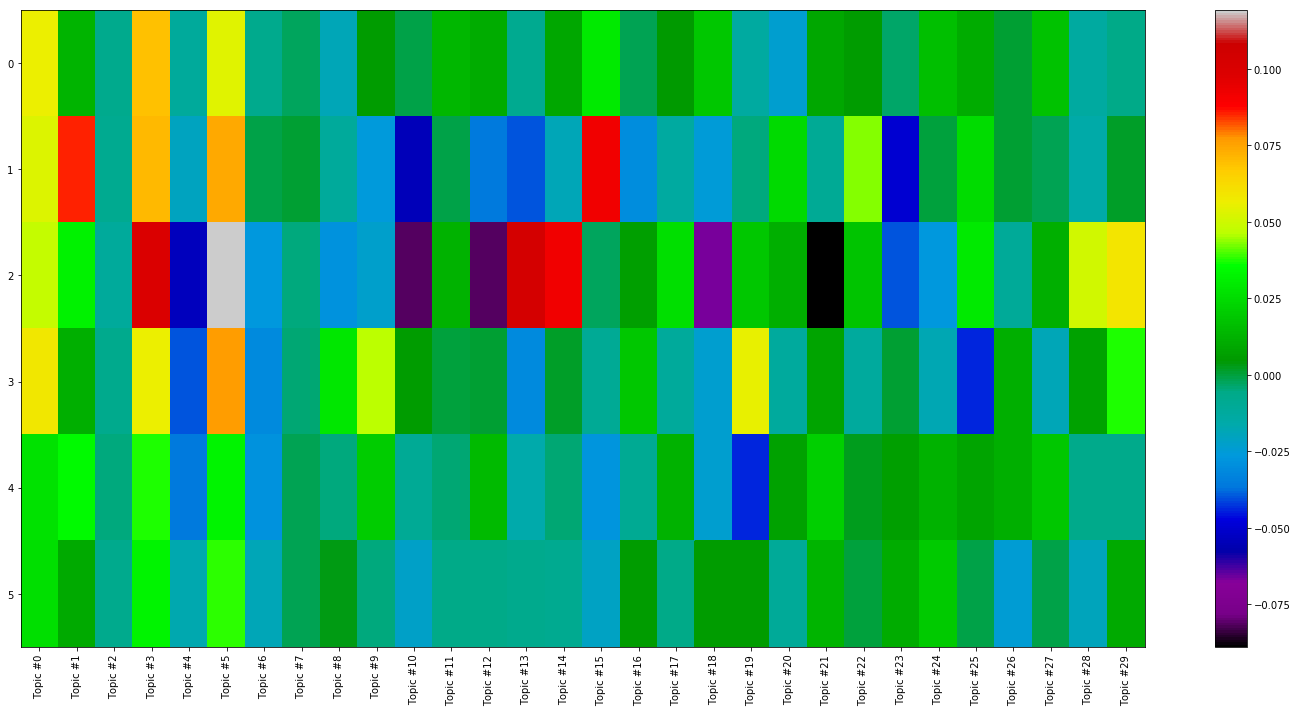

In [293]:
plot_topic_val(corpus_lsi[:6], topic_num, 20, 10)

## Training LDA model
Gensim also supports LDA model training. 

In [318]:
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix_sample, num_topics=topic_num, 
               id2word = dictionary_sample, passes=50, minimum_probability = 0.0001)

In [319]:
topic_words_lda = ldamodel.show_topics(num_topics=topic_num, formatted=False)
corpus_lda = ldamodel.get_document_topics(corpus_tfidf, minimum_phi_value=1e-10)

In [322]:
print(corpus_lda[0])

[(0, 0.0037847916), (1, 0.0037847916), (2, 0.0037847916), (3, 0.0037847916), (4, 0.0037847916), (5, 0.0037847916), (6, 0.0037847916), (7, 0.0037847916), (8, 0.0037847916), (9, 0.0037847916), (10, 0.0037847916), (11, 0.0037847916), (12, 0.0037847916), (13, 0.890241), (14, 0.0037847916), (15, 0.0037847916), (16, 0.0037847916), (17, 0.0037847916), (18, 0.0037847916), (19, 0.0037847916), (20, 0.0037847916), (21, 0.0037847916), (22, 0.0037847916), (23, 0.0037847916), (24, 0.0037847916), (25, 0.0037847916), (26, 0.0037847916), (27, 0.0037847916), (28, 0.0037847916), (29, 0.0037847916)]


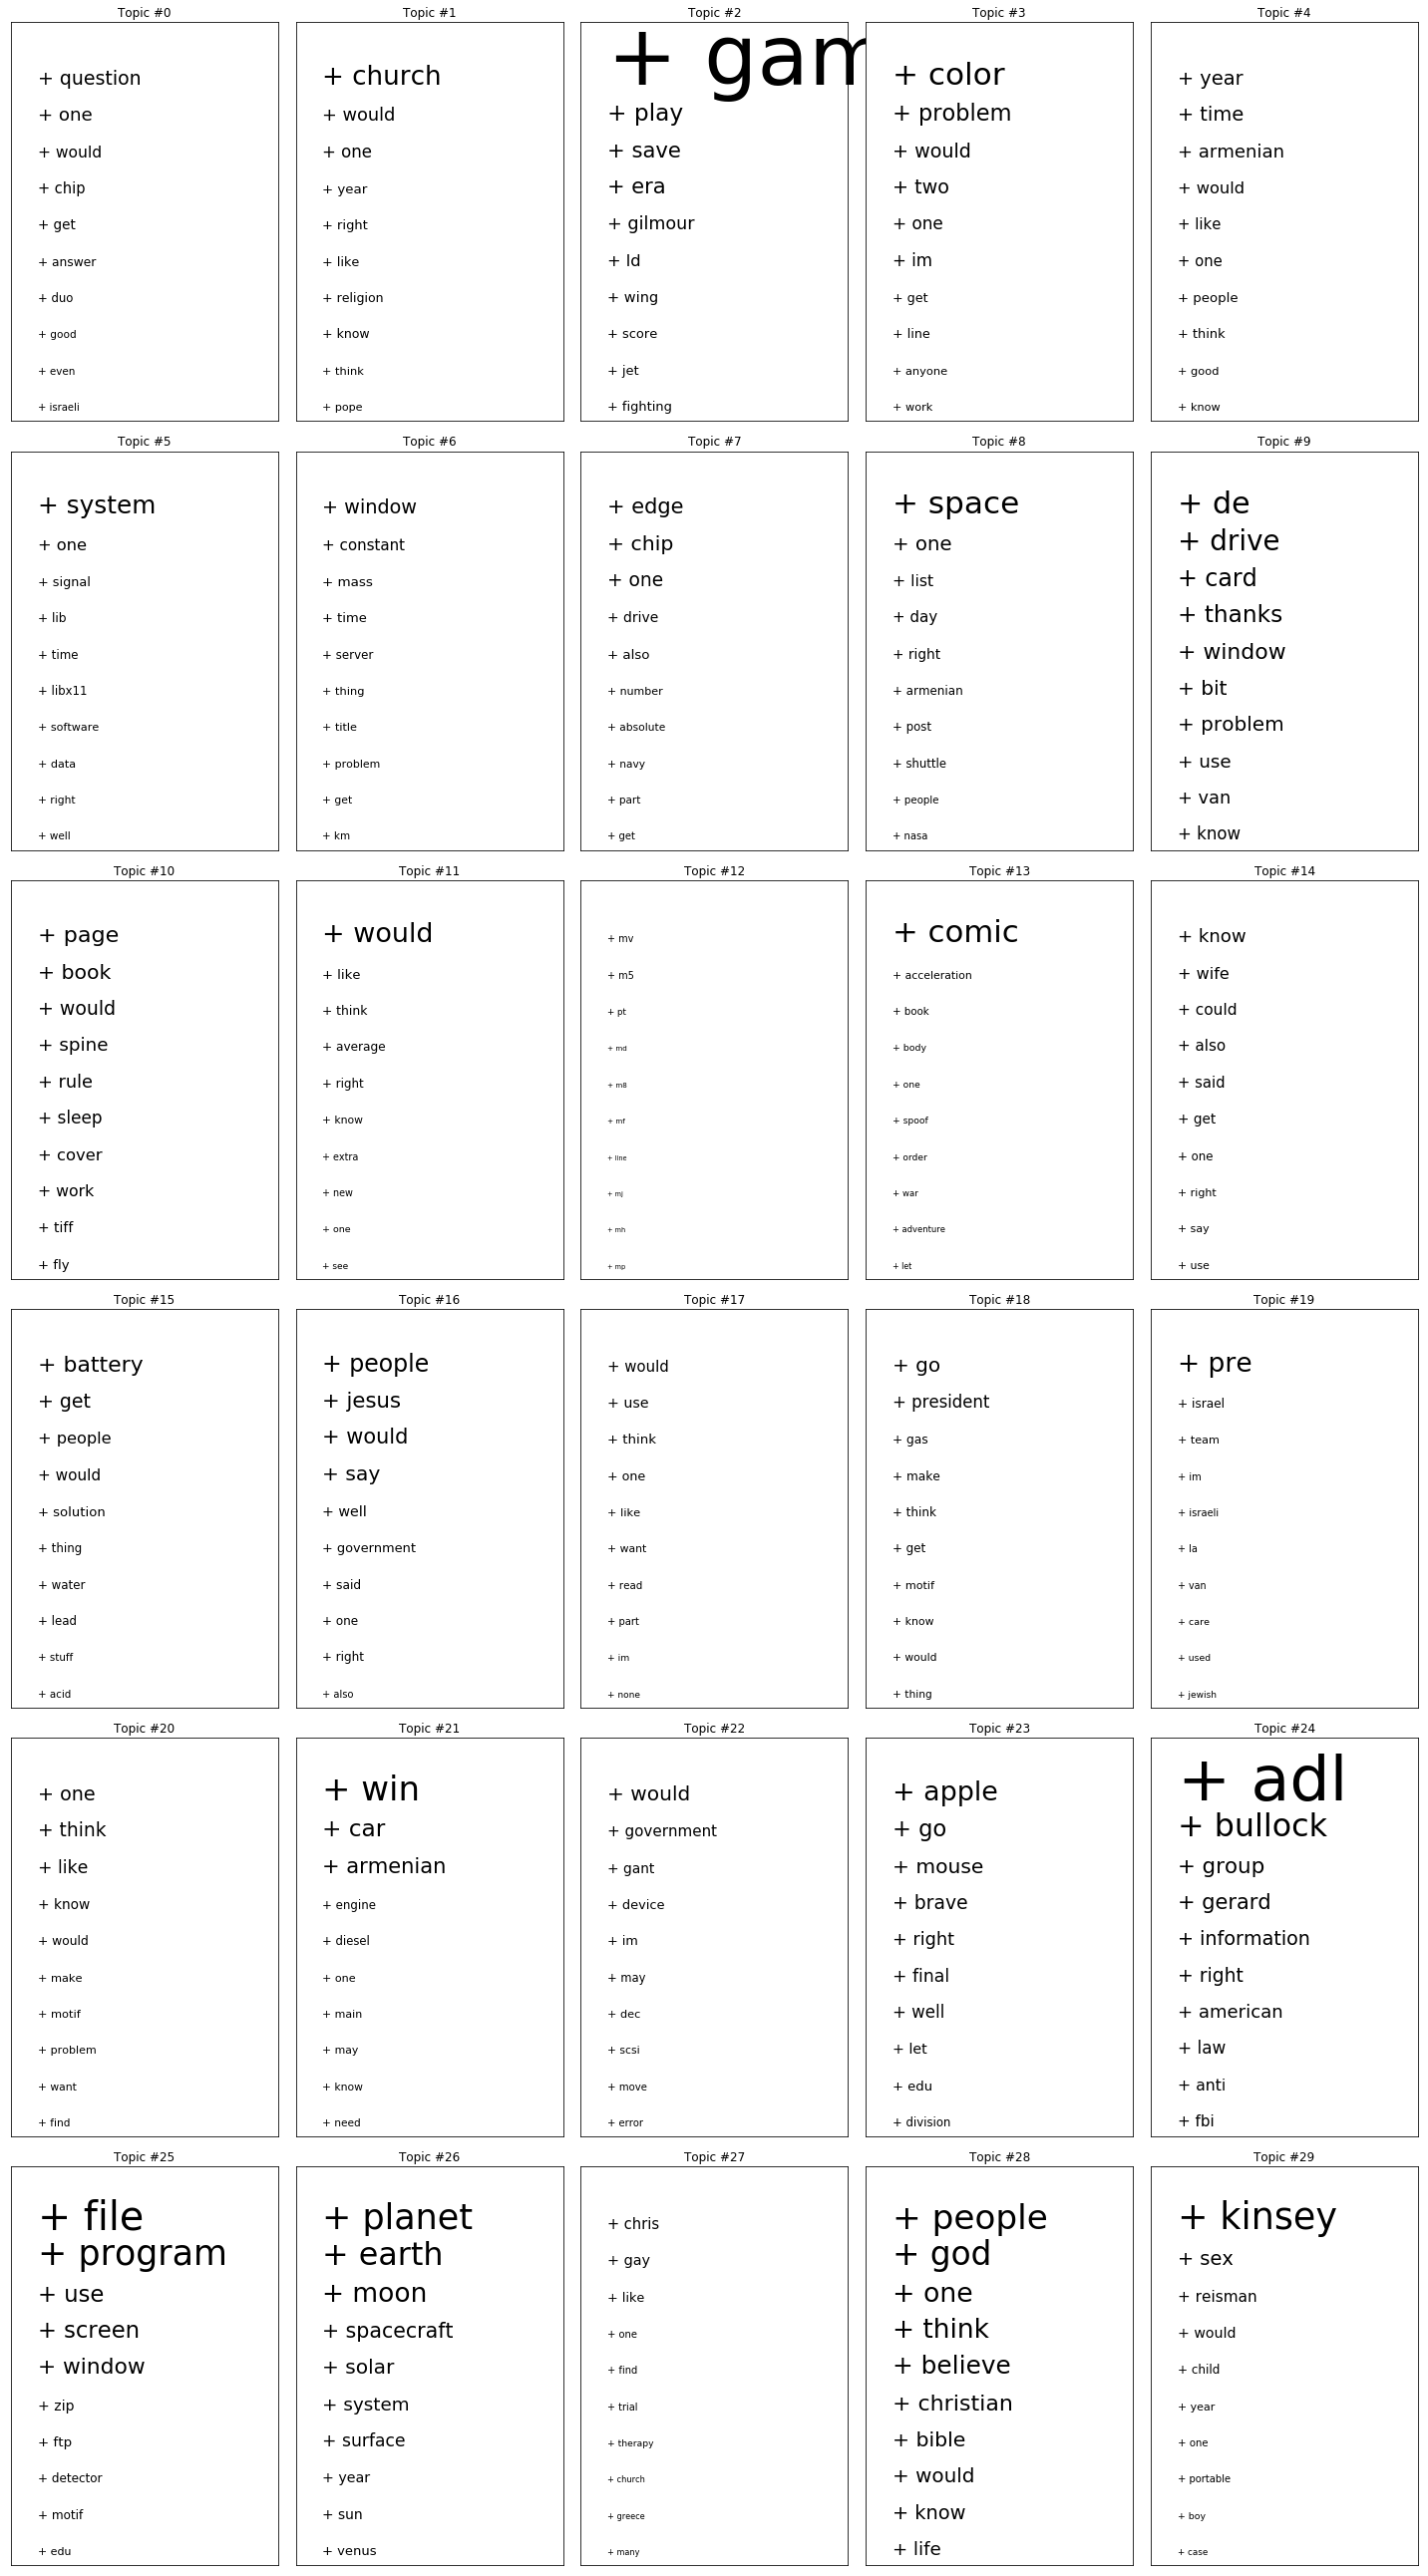

In [323]:
plot_topicwords(10, topic_words_lda, 20, 36, 2500)

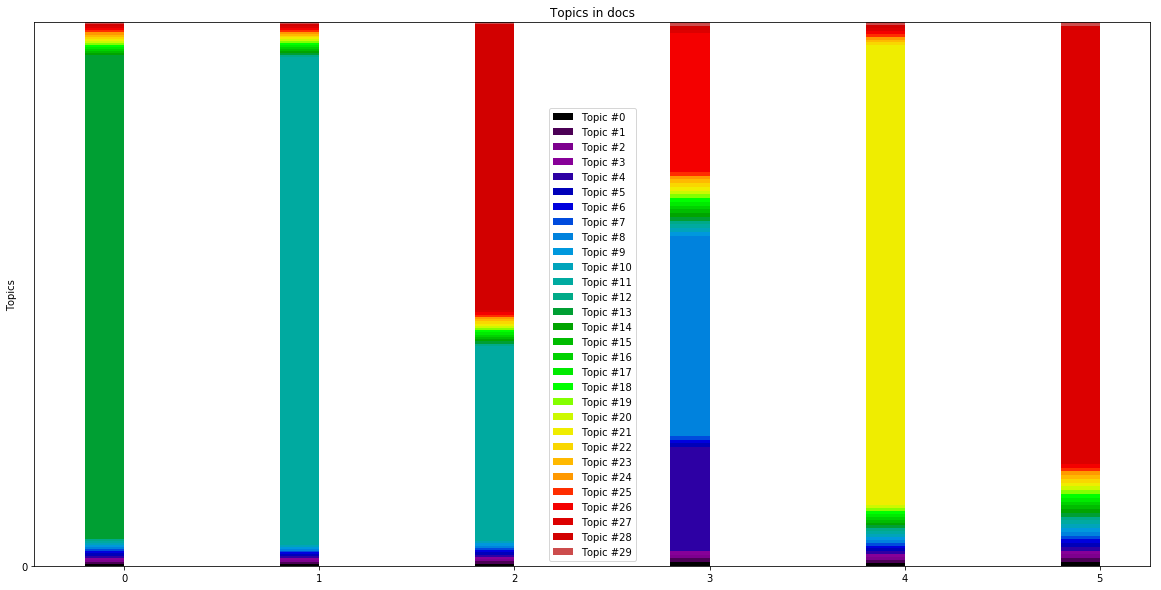

In [324]:
plot_topic_share(corpus_lda[:6], topic_num, 20, 10)

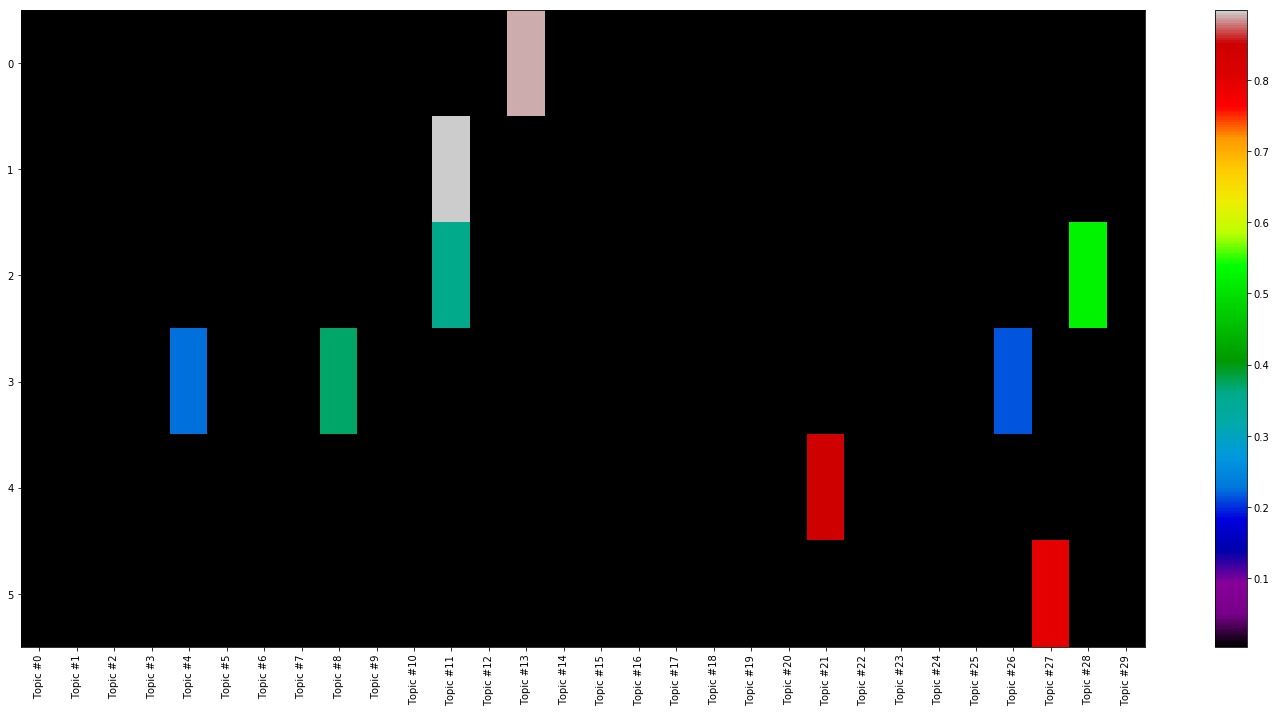

In [325]:
plot_topic_val(corpus_lda[:6], topic_num, 20, 10)

Processing with the data from 20newsgroups

In [50]:
# id2word = gensim.corpora.Dictionary.load_from_text('data/wiki_en_wordids.txt')

In [55]:
# print(len(id2word))

100000


In [16]:
# from sklearn.datasets import fetch_20newsgroups

In [30]:
# newsgroups = fetch_20newsgroups(subset='all',remove=('headers', 'footers', 'quotes'))

In [31]:
# from pprint import pprint
# pprint(list(newsgroups.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [32]:
# print(type(newsgroups.data[0]))

<class 'str'>


In [46]:
# print(len(newsgroups.data))
# print(newsgroups.data[200])

18846

Jesus did and so do I.

Peace be with you,


In [47]:
# doc_clean = [process(doc).split() for doc in newsgroups.data]

NameError: name 'process' is not defined

In [5]:
# # test for simple samples

# doc1 = "Sugar is bad to consume. My sister likes to have sugar, but not my father."
# doc2 = "My father spends a lot of time driving my sister around to dance practice."
# doc3 = "Doctors suggest that driving may cause increased stress and blood pressure."
# doc4 = "Sometimes I feel pressure to perform well at school, but my father never seems to drive my sister to do better."
# doc5 = "Health experts say that Sugar is not good for your lifestyle."

# doc_complete = [doc1, doc2, doc3, doc4, doc5]

In [6]:
# from nltk.corpus import stopwords 
# from nltk.stem.wordnet import WordNetLemmatizer
# import string
# stop = set(stopwords.words('english'))
# exclude = set(string.punctuation) 
# lemma = WordNetLemmatizer()
# def clean(doc):
#     stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
#     punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
#     normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
#     return normalized

# doc_clean = [clean(doc).split() for doc in doc_complete]   

In [37]:
# # Importing Gensim
# import gensim
# from gensim import corpora

# # Creating the term dictionary of our courpus, where every unique term is assigned an index. 
# dictionary = corpora.Dictionary(doc_clean)

# # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
# doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [41]:
# # Creating the object for LDA model using gensim library

# start = time.time()
# Lda = gensim.models.ldamodel.LdaModel
# Lsi = gensim.models.lsimodel.LsiModel

# # Running and Trainign LDA model on the document term matrix.
# ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)
# lsimodel = Lsi(doc_term_matrix, num_topics=3, id2word = dictionary)

# end = time.time()

# print(str(end - start))

704.1523542404175


In [42]:
# print(ldamodel.print_topics(num_topics=3, num_words=10))

[(0, '0.005*"one" + 0.005*"would" + 0.004*"year" + 0.004*"get" + 0.003*"time" + 0.003*"like" + 0.003*"game" + 0.003*"well" + 0.003*"also" + 0.003*"know"'), (1, '0.009*"1" + 0.007*"x" + 0.006*"2" + 0.006*"0" + 0.006*"file" + 0.004*"window" + 0.004*"use" + 0.004*"system" + 0.004*"image" + 0.004*"3"'), (2, '0.007*"would" + 0.007*"one" + 0.007*"people" + 0.006*"god" + 0.004*"think" + 0.004*"say" + 0.004*"it" + 0.004*"know" + 0.004*"maxaxaxaxaxaxaxaxaxaxaxaxaxaxax" + 0.003*"like"')]


In [43]:
# print(lsimodel.print_topics(num_topics=3, num_words=10))

[(0, '0.976*"x" + 0.097*"file" + 0.079*"entry" + 0.052*"program" + 0.051*"0" + 0.035*"oname" + 0.033*"output" + 0.030*"char" + 0.030*"line" + 0.028*"section"'), (1, '0.700*"0" + 0.470*"1" + 0.390*"2" + 0.205*"3" + 0.155*"4" + 0.080*"5" + 0.078*"6" + -0.069*"x" + 0.068*"7" + 0.053*"8"'), (2, '1.000*"maxaxaxaxaxaxaxaxaxaxaxaxaxaxax" + 0.008*"mg9vg9vg9vg9vg9vg9vg9vg9vg9vg9vg9vg9vg9vg9vg9v" + 0.004*"14" + 0.004*"part" + 0.003*"maxaxaxaxaxaxaxaxaxaxaxaxaxaxaxq" + 0.002*"end" + 0.002*"m8axaxaxaxaxaxaxaxaxaxaxaxaxax" + 0.001*"maxaxaxaxaxaxaxaxaxaxaxaxaxaxasq" + 0.001*"maxaxaxaxaxaxaxaxaxaxaxaxaxax1f" + -0.001*"0"')]


In [9]:
# from gensim.test.utils import common_dictionary, common_corpus
# from gensim.models import LsiModel


In [11]:
# print(common_dictionary)

Dictionary(12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...)
